# Import Required Library

In [72]:
import numpy as np 
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from string import punctuation
from nltk.corpus import stopwords
from collections import Counter
from wordcloud import WordCloud, STOPWORDS
import re
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load Dataset

In [57]:
df = pd.read_csv('C:/Users/hulin/Downloads/covid19_tweets.csv') # Dataset used for this analysis
sentiment=pd.read_csv('C:/Users/hulin/Downloads/training.1600000.processed.noemoticon.csv'
                      ,encoding = 'latin',header=None,names=['target','id','time','query','usr','text']) #Dataset for modeling

# Define helper functions

In [118]:
def find_missing(data_frame):
    missing_df = data_frame.isnull().sum()/len(data_frame)
    missing_df = missing_df[missing_df>0]
    missing_df.sort_values(inplace=True)
    return missing_df

def plot_missing(data_frame):
    missing_values = find_missing(data_frame)
    missing_values = missing_values.to_frame()
    missing_values.columns = ['count']
    missing_values.index.names = ['Name']
    missing_values['Name'] = missing_values.index
    sns.set(style="whitegrid", color_codes=True)
    sns.barplot(x='Name', y='count', data=missing_values)
    plt.xticks(rotation=90)
    plt.show()
    
def find_unique(data_frame):
    unique_dataframe = pd.DataFrame()
    unique_dataframe['Features'] = data_frame.columns
    uniques = []
    for col in data_frame.columns:
        u = data_frame[col].nunique()
        uniques.append(u)
    unique_dataframe['Uniques'] = uniques
    return unique_dataframe  

def plot_unique(data_frame):
    udf = find_unique(data_frame)
    sns.barplot(x=udf['Features'], y=udf['Uniques'], alpha=0.8)
    plt.title('Bar plot for #unique values in each column')
    plt.ylabel('#Unique values', fontsize=12)
    plt.xlabel('Features', fontsize=12)
    plt.xticks(rotation=90)
    plt.show()  
    
def plot_frequency_charts(df, feature, title, pallete):
    freq_df = pd.DataFrame()
    freq_df[feature] = df[feature]
    
    f, ax = plt.subplots(1,1, figsize=(16,4))
    total = float(len(df))
    g = sns.countplot(df[feature], order = df[feature].value_counts().index[:20], palette=pallete)
    g.set_title("Number and percentage of {}".format(title))

    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(100*height/total),
                ha="center") 

    plt.title('Frequency of {} tweeting about Corona'.format(feature))
    plt.ylabel('Frequency', fontsize=12)
    plt.xlabel(title, fontsize=12)
    plt.xticks(rotation=90)
    plt.show()

def punctuation_stopwords_removal(sms):
    remove_punctuation = [ch for ch in sms if ch not in punctuation]
    remove_punctuation = "".join(remove_punctuation).split()
    filtered_sms = [word.lower() for word in remove_punctuation if word.lower() not in stopwords.words('english')]
    return filtered_sms

def draw_bar_graph_for_text_visualization(df, location,column,emotion):
    if emotion == 0:
        colormap="Greens"
        tweets_from_loc = df.loc[(df.user_location==location) & (df.pred_sentiment == 0)]
    elif emotion == 1:
        colormap = 'Reds'
        tweets_from_loc = df.loc[(df.user_location==location) & (df.pred_sentiment == 1)]
    elif emotion == 2:
        colormap = 'viridis'
        tweets_from_loc = df.loc[df.user_location==location]
        
    tweets_from_loc.loc[:, column] = tweets_from_loc[column].apply(punctuation_stopwords_removal)
    loc_tweets_curated = tweets_from_loc[column].tolist()
    loc_tweet_list = []
    for sublist in loc_tweets_curated:
        for word in sublist:
            loc_tweet_list.append(word)
    loc_tweet_count = Counter(loc_tweet_list)
    loc_top_30_words = pd.DataFrame(loc_tweet_count.most_common(50), columns=['word', 'count'])
    fig, ax = plt.subplots(figsize=(16, 6))
    sns.barplot(x='word', y='count', 
                data=loc_top_30_words, ax=ax)
    plt.title("Top 50 Prevelant Words in {}".format(location))
    plt.xticks(rotation='vertical');
    
def draw_word_cloud(df, location, title,column,emotion):
    if emotion == 0:
        colormap="Reds"
        loc_df = df.loc[(df.user_location==location) & (df.pred_sentiment == 0)]
    elif emotion == 1:
        colormap = 'Greens'
        loc_df = df.loc[(df.user_location==location) & (df.pred_sentiment == 1)]
    elif emotion == 2:
        colormap = 'viridis'
        loc_df = df.loc[df.user_location==location]
    loc_df.loc[:, column] = loc_df[column].apply(punctuation_stopwords_removal)
    word_cloud = WordCloud(
                    background_color='white',
                    colormap = colormap,
                    stopwords=set(STOPWORDS),
                    max_words=50,
                    max_font_size=40,
                    scale=5,
                    random_state=1).generate(str(loc_df[column]))
    fig = plt.figure(1, figsize=(10,10))
    plt.axis('off')
    fig.suptitle(title, fontsize=20)
    fig.subplots_adjust(top=2.3)
    plt.imshow(word_cloud)
    plt.show()
    
def remove_tag(string):
    text=re.sub('<.*?>','',string)
    return text
def remove_mention(text):
    line=re.sub(r'@\w+','',text)
    return line
def remove_hash(text):
    line=re.sub(r'#\w+','',text)
    return line

def remove_newline(string):
    text=re.sub('\n','',string)
    return text
def remove_url(string): 
    text = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+','',string)
    return text
def remove_number(text):
    line=re.sub(r'[0-9]+','',text)
    return line
def remove_punct(text):
    line = re.sub(r'[!"\$%&\'()*+,\-.\/:;=#@?\[\\\]^_`{|}~]*','',text)
    #string="".join(line)
    return line
def text_strip(string):
    line=re.sub('\s{2,}', ' ', string.strip())
    return line
def remove_thi_amp_ha_words(string):
    line=re.sub(r'\bamp\b|\bthi\b|\bha\b',' ',string)
    return line

In [79]:
df['refine_text']=df['text'].str.lower()
df['refine_text']=df['refine_text'].apply(lambda x:remove_tag(str(x)))
df['refine_text']=df['refine_text'].apply(lambda x:remove_mention(str(x)))
df['refine_text']=df['refine_text'].apply(lambda x:remove_hash(str(x)))
df['refine_text']=df['refine_text'].apply(lambda x:remove_newline(x))
df['refine_text']=df['refine_text'].apply(lambda x:remove_url(x))
df['refine_text']=df['refine_text'].apply(lambda x:remove_number(x))
df['refine_text']=df['refine_text'].apply(lambda x:remove_punct(x))
df['refine_text']=df['refine_text'].apply(lambda x:remove_thi_amp_ha_words(x))
df['refine_text']=df['refine_text'].apply(lambda x:text_strip(x))
df['text_length']=df['refine_text'].str.split().map(lambda x: len(x))

In [90]:
df.head()

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,refine_text,text_length
0,ᏉᎥ☻լꂅϮ,astroworld,wednesday addams as a disney princess keepin i...,2017-05-26 05:46:42,624,950,18775,False,2020-07-25 12:27:21,If I smelled the scent of hand sanitizers toda...,NaN,Twitter for iPhone,False,if i smelled the scent of hand sanitizers toda...,22
1,Tom Basile 🇺🇸,"New York, NY","Husband, Father, Columnist & Commentator. Auth...",2009-04-16 20:06:23,2253,1677,24,True,2020-07-25 12:27:17,Hey @Yankees @YankeesPR and @MLB - wouldn't it...,NaN,Twitter for Android,False,hey and wouldnt it have made more sense to hav...,18
2,Time4fisticuffs,"Pewee Valley, KY",#Christian #Catholic #Conservative #Reagan #Re...,2009-02-28 18:57:41,9275,9525,7254,False,2020-07-25 12:27:14,@diane3443 @wdunlap @realDonaldTrump Trump nev...,['COVID19'],Twitter for Android,False,trump never once claimed was a hoax we all cla...,14
3,ethel mertz,Stuck in the Middle,#Browns #Indians #ClevelandProud #[]_[] #Cavs ...,2019-03-07 01:45:06,197,987,1488,False,2020-07-25 12:27:10,@brookbanktv The one gift #COVID19 has give me...,['COVID19'],Twitter for iPhone,False,the one gift has give me is an appreciation fo...,18
4,DIPR-J&K,Jammu and Kashmir,🖊️Official Twitter handle of Department of Inf...,2017-02-12 06:45:15,101009,168,101,False,2020-07-25 12:27:08,25 July : Media Bulletin on Novel #CoronaVirus...,"['CoronaVirusUpdates', 'COVID19']",Twitter for Android,False,july media bulletin on novel …,6


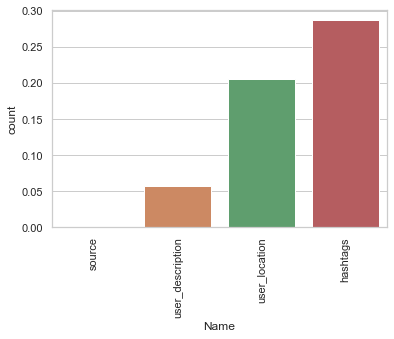

In [33]:
plot_missing(df)

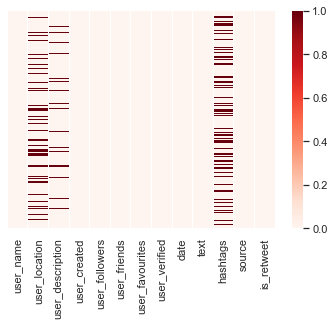

In [34]:
sns.heatmap(df.isnull(), cbar=True, yticklabels=False, cmap='Reds')

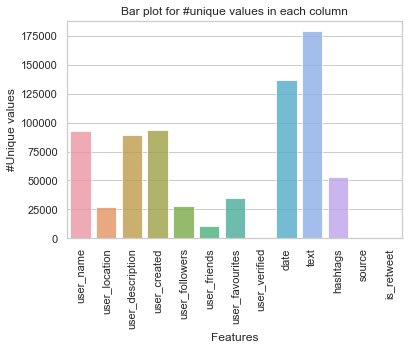

In [35]:
plot_unique(df)

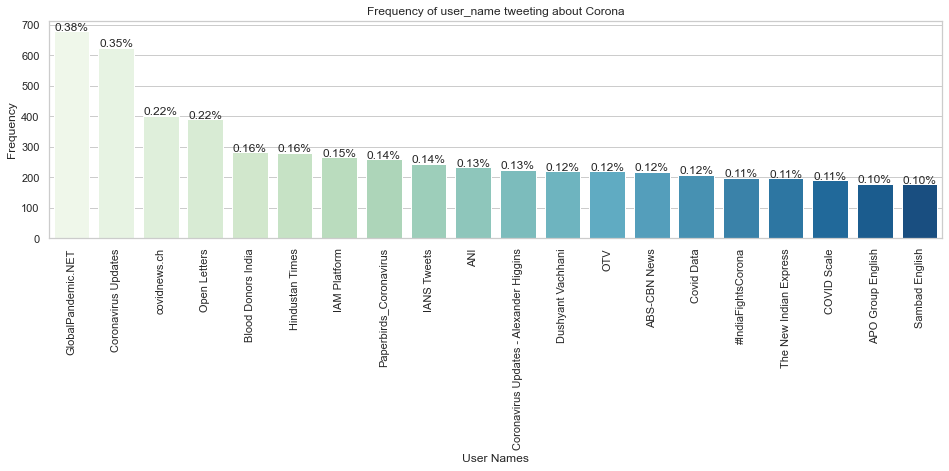

In [37]:
plot_frequency_charts(df, 'user_name', 'User Names','GnBu')

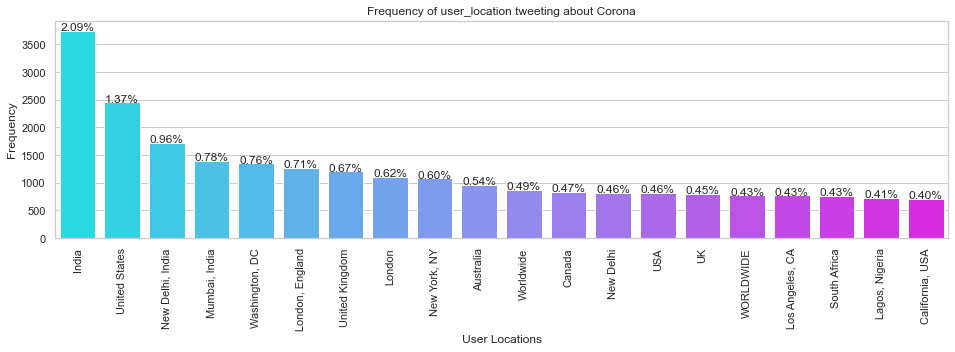

In [38]:
plot_frequency_charts(df, 'user_location', 'User Locations', 'cool')

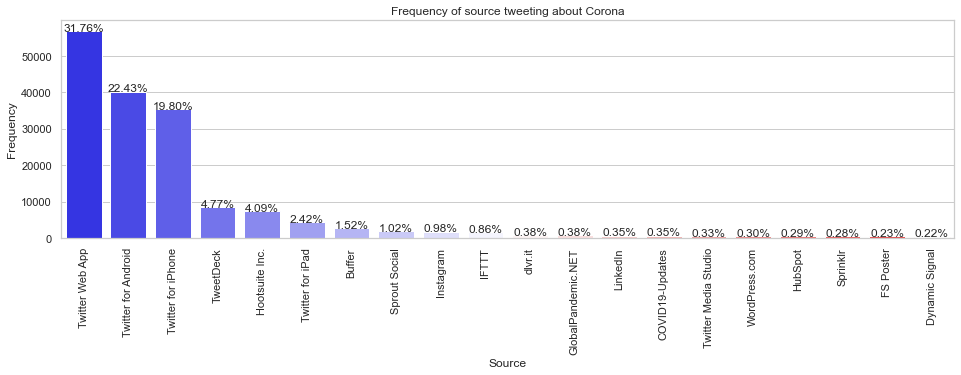

In [42]:
plot_frequency_charts(df, 'source','Source', 'bwr')

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


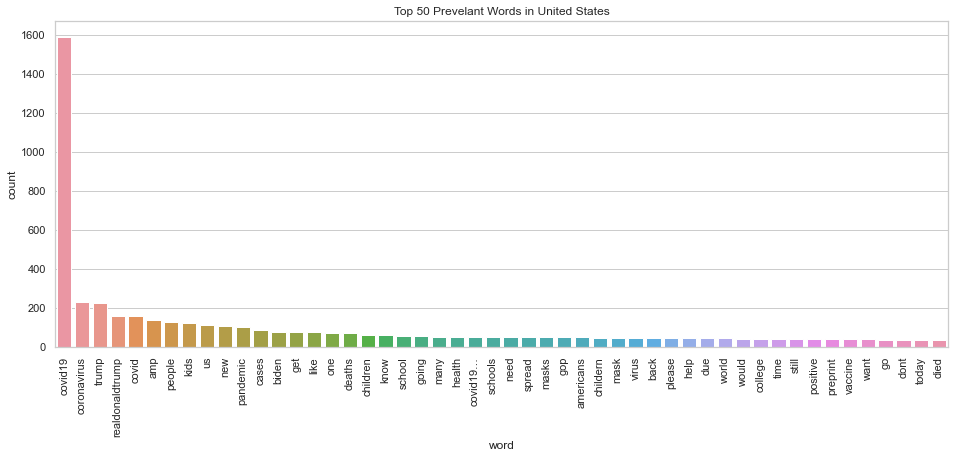

In [97]:
draw_bar_graph_for_text_visualization(df, 'United States','text',2)

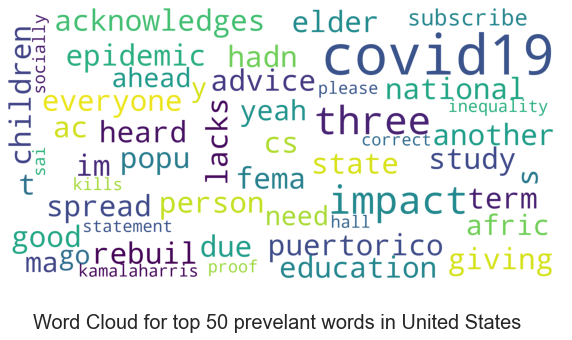

In [98]:
draw_word_cloud(df, 'United States', 'Word Cloud for top 50 prevelant words in United States','text',2)

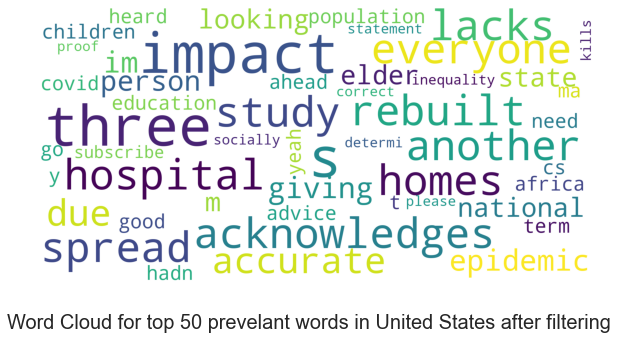

In [103]:
draw_word_cloud(df, 'United States', 'Word Cloud for top 50 prevelant words in United States after filtering','refine_text',2)

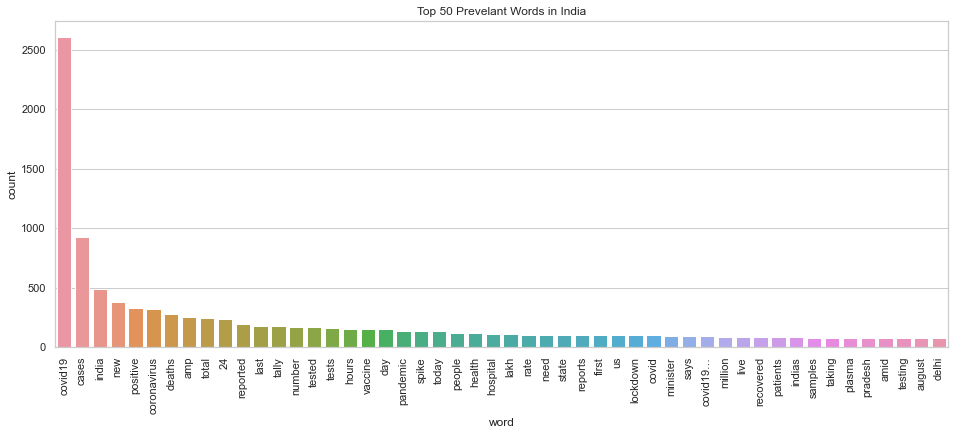

In [100]:
draw_bar_graph_for_text_visualization(df, 'India','text',2)

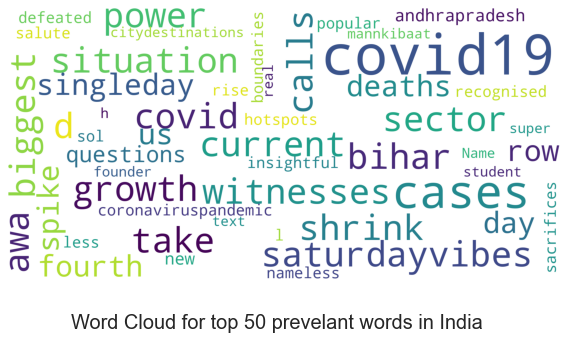

In [101]:
draw_word_cloud(df, 'India', 'Word Cloud for top 50 prevelant words in India','text',2)

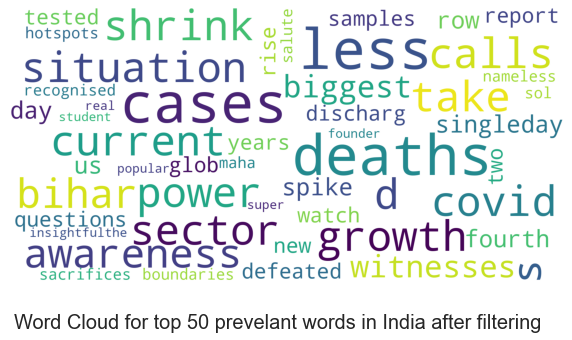

In [104]:
draw_word_cloud(df, 'India', 'Word Cloud for top 50 prevelant words in India after filtering','refine_text',2)

# Modeling

In [67]:
sentiment=sentiment.sample(int(sentiment.shape[0]*0.4))
sentiment=sentiment[['text','target']]
sentiment['emotion']=np.where(sentiment['target']==0,'negative',np.where(sentiment['target']==2,'neutral',np.where(sentiment['target']==4,'postitive',"none")))
sentiment['target']=np.where(sentiment['target']==4,1,sentiment['target'])

# Optimizing text
sentiment['refine_text']=sentiment['text'].str.lower()
sentiment['refine_text']=sentiment['refine_text'].apply(lambda x:remove_tag(str(x)))
sentiment['refine_text']=sentiment['refine_text'].apply(lambda x:remove_mention(str(x)))
sentiment['refine_text']=sentiment['refine_text'].apply(lambda x:remove_hash(str(x)))
sentiment['refine_text']=sentiment['refine_text'].apply(lambda x:remove_newline(x))
sentiment['refine_text']=sentiment['refine_text'].apply(lambda x:remove_url(x))
sentiment['refine_text']=sentiment['refine_text'].apply(lambda x:remove_number(x))
sentiment['refine_text']=sentiment['refine_text'].apply(lambda x:remove_punct(x))
sentiment['refine_text']=sentiment['refine_text'].apply(lambda x:remove_thi_amp_ha_words(x))
sentiment['refine_text']=sentiment['refine_text'].apply(lambda x:text_strip(x))
sentiment['text_length']=sentiment['refine_text'].str.split().map(lambda x: len(x))

# Removing stopwords
stop_words = set(stopwords.words('english'))
sentiment['refine_text'] =  sentiment['refine_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

# Setting tha randomly
train_data=sentiment[['refine_text','target']]

train_sent=np.array(train_data['refine_text'])
train_label=np.array(train_data['target'])

x_train, x_test, y_train, y_test = train_test_split(train_sent, train_label, test_size=0.20, random_state=42)

## Turning Parameters

In [68]:
# Hyper Parameters
vocab_size = 1000
embedding_dim =16 
max_length = 50
trunc_type='post'
oov_tok = "<OOV>"

In [73]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(x_train)
word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(x_train)
training_padded = pad_sequences(training_sequences,maxlen=max_length, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(x_test)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length)

training_label=y_train
testing_label=y_test

In [74]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')

])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 16)            16000     
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 16,289
Trainable params: 16,289
Non-trainable params: 0
_________________________________________________________________


In [75]:
num_epochs = 12
history=model.fit(training_padded, training_label, epochs=num_epochs, validation_data=(testing_padded, testing_label))

Epoch 1/12
1024/1024 [==============================] - 1s 790us/step - loss: 0.6592 - accuracy: 0.6156 - val_loss: 0.5911 - val_accuracy: 0.6796
Epoch 2/12
1024/1024 [==============================] - 1s 657us/step - loss: 0.5445 - accuracy: 0.7286 - val_loss: 0.5331 - val_accuracy: 0.7432
Epoch 3/12
1024/1024 [==============================] - 1s 656us/step - loss: 0.5238 - accuracy: 0.7419 - val_loss: 0.5278 - val_accuracy: 0.7451
Epoch 4/12
1024/1024 [==============================] - 1s 673us/step - loss: 0.5166 - accuracy: 0.7468 - val_loss: 0.5274 - val_accuracy: 0.7426
Epoch 5/12
1024/1024 [==============================] - 1s 660us/step - loss: 0.5139 - accuracy: 0.7483 - val_loss: 0.5293 - val_accuracy: 0.7389
Epoch 6/12
1024/1024 [==============================] - 1s 659us/step - loss: 0.5115 - accuracy: 0.7501 - val_loss: 0.5282 - val_accuracy: 0.7408
Epoch 7/12
1024/1024 [==============================] - 1s 657us/step - loss: 0.5098 - accuracy: 0.7494 - val_loss: 0.5290 -

# Prediction

In [85]:
sen = np.array(df.refine_text)
seq = tokenizer.texts_to_sequences(sen)
padd = pad_sequences(seq, maxlen=max_length, truncating=trunc_type)
result=model.predict(padd)
validated_result=np.where(result>0.5,1,0)

In [112]:
pred_df=pd.DataFrame({'text':df['refine_text'],'pred_sentiment':list(validated_result),'user_location':df['user_location'],'text_length':df['text_length']})
pred_df['pred_sentiment']=np.where(pred_df['pred_sentiment']>0.5,1,0)
pred_df.head(4)

,text,pred_sentiment,user_location,text_length
0,if i smelled the scent of hand sanitizers toda...,1,astroworld,22
1,hey and wouldnt it have made more sense to hav...,1,"New York, NY",18
2,trump never once claimed was a hoax we all cla...,0,"Pewee Valley, KY",14
3,the one gift has give me is an appreciation fo...,1,Stuck in the Middle,18


In [113]:
df['pred_sentiment'] = list(validated_result)
df['pred_sentiment']=np.where(df['pred_sentiment']>0.5,1,0)
df.head(4)

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,refine_text,text_length,pred_sentiment
0,ᏉᎥ☻լꂅϮ,astroworld,wednesday addams as a disney princess keepin i...,2017-05-26 05:46:42,624,950,18775,False,2020-07-25 12:27:21,If I smelled the scent of hand sanitizers toda...,NaN,Twitter for iPhone,False,if i smelled the scent of hand sanitizers toda...,22,1
1,Tom Basile 🇺🇸,"New York, NY","Husband, Father, Columnist & Commentator. Auth...",2009-04-16 20:06:23,2253,1677,24,True,2020-07-25 12:27:17,Hey @Yankees @YankeesPR and @MLB - wouldn't it...,NaN,Twitter for Android,False,hey and wouldnt it have made more sense to hav...,18,1
2,Time4fisticuffs,"Pewee Valley, KY",#Christian #Catholic #Conservative #Reagan #Re...,2009-02-28 18:57:41,9275,9525,7254,False,2020-07-25 12:27:14,@diane3443 @wdunlap @realDonaldTrump Trump nev...,['COVID19'],Twitter for Android,False,trump never once claimed was a hoax we all cla...,14,0
3,ethel mertz,Stuck in the Middle,#Browns #Indians #ClevelandProud #[]_[] #Cavs ...,2019-03-07 01:45:06,197,987,1488,False,2020-07-25 12:27:10,@brookbanktv The one gift #COVID19 has give me...,['COVID19'],Twitter for iPhone,False,the one gift has give me is an appreciation fo...,18,1


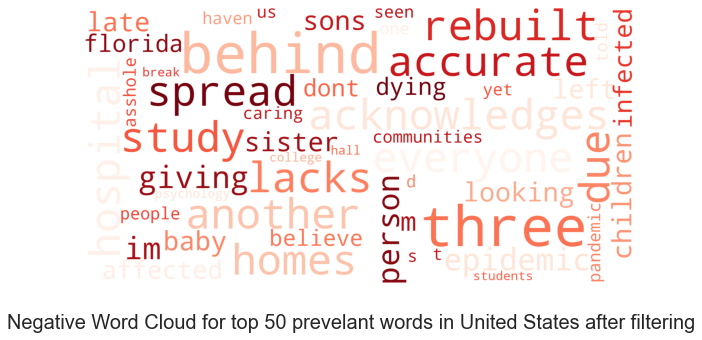

In [119]:
draw_word_cloud(df, 'United States', 'Negative Word Cloud for top 50 prevelant words in United States after filtering','refine_text',0)

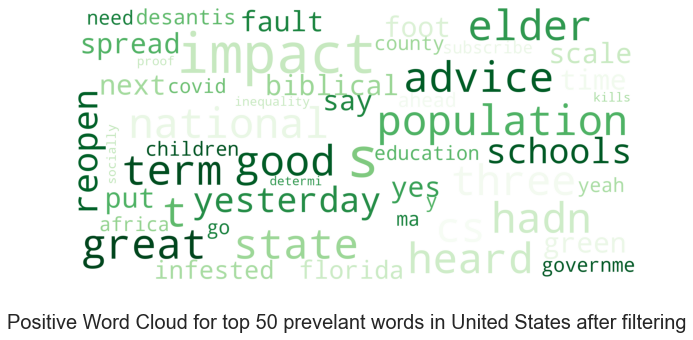

In [120]:
draw_word_cloud(df, 'United States', 'Positive Word Cloud for top 50 prevelant words in United States after filtering','refine_text',1)

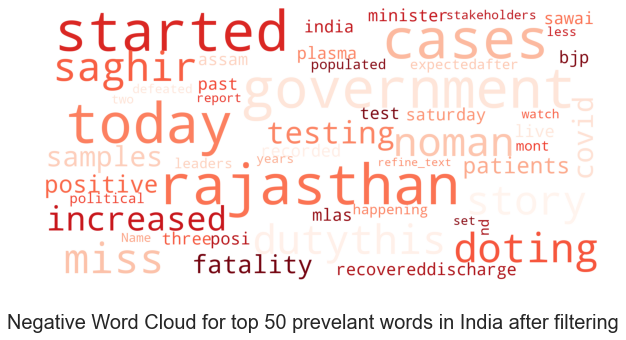

In [123]:
draw_word_cloud(df, 'India', 'Negative Word Cloud for top 50 prevelant words in India after filtering','refine_text',0)

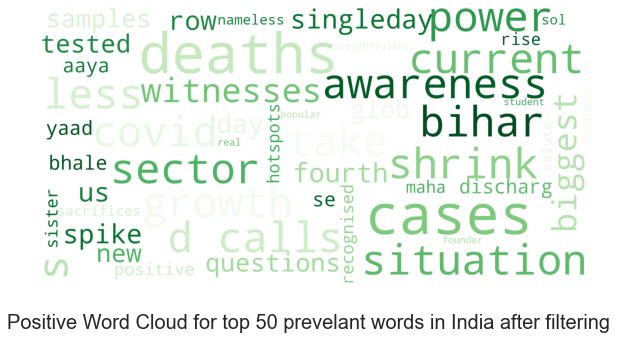

In [124]:
draw_word_cloud(df, 'India', 'Positive Word Cloud for top 50 prevelant words in India after filtering','refine_text',1)